Look at the results of adding elevation data. See the impact on performance for samples with satellite imagery vs. samples with only elevation data

In [1]:
# %load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import shutil
import yaml

from cloudpathlib import AnyPath
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from zipfile import ZipFile

from cyano.data.utils import add_unique_identifier
from cyano.evaluate import (
    EvaluatePreds,
    generate_and_plot_crosstab,
    generate_actual_density_boxplot,
    generate_regional_barplot,
    generate_density_scatterplot,
    generate_density_kdeplot,
)

In [3]:
s3_dir = AnyPath("s3://drivendata-competition-nasa-cyanobacteria/experiments")

## Load data

In [4]:
# load ground truth
true_path = s3_dir / "splits/competition/test.csv"
true = pd.read_csv(true_path, index_col=0)
true.shape

(6510, 9)

In [90]:
# load predictions
preds = pd.read_csv(
    s3_dir / "results/third_sentinel_and_elevation/preds.csv", index_col=0
)
preds.shape, preds.severity.isna().sum()

((6510, 5), 0)

In [7]:
# Load test features to see which samples had satellite imagery
test_features = pd.read_csv(
    s3_dir / "results/third_sentinel_and_elevation/features_test.csv"
)
test_features.shape, test_features.sample_id.nunique()

((23178, 70), 6510)

In [8]:
test_features.head(2)

,sample_id,AOT_mean,AOT_min,AOT_max,AOT_range,B01_mean,B01_min,B01_max,B01_range,B02_mean,...,WVP_range,NDVI_B04,NDVI_B05,NDVI_B06,NDVI_B07,month,days_before_sample,elevation_max,elevation_range,elevation_at_sample
0,00028d54fa33b3b90a70eda38c1d94c4,126.0,126.0,126.0,0.0,685.530612,432.0,1742.0,1310.0,822.126417,...,844.0,0.288753,0.203835,0.068435,0.029072,9.0,6.0,74.046875,73.056854,10.907775
1,00028d54fa33b3b90a70eda38c1d94c4,114.0,114.0,114.0,0.0,643.408163,351.0,1668.0,1317.0,819.565760,...,730.0,0.287023,0.193409,0.063530,0.019663,9.0,11.0,74.046875,73.056854,10.907775


In [9]:
# all satellite features have the same number of missing values
test_features.isna().sum().value_counts()

1686    66
0        4
Name: count, dtype: int64

In [10]:
# no elevation features are missing in this dataframe
test_features.filter(regex='elevation').isna().any()

elevation_max          False
elevation_range        False
elevation_at_sample    False
dtype: bool

In [11]:
test_features["has_satellite"] = test_features.AOT_mean.notna()

In [12]:
test = pd.read_csv(s3_dir / "splits/competition/test.csv")
test = add_unique_identifier(test)
test["date"] = pd.to_datetime(test.date)
test.head(2)

,uid,data_provider,region,latitude,longitude,date,density_cells_per_ml,severity,distance_to_water_m,log_density
sample_id,,,,,,,,,,
4a89ead93e2caa84da636236bb361e12,aabn,California Environmental Data Exchange Network,west,36.5597,-121.510,2016-08-31,5867500.0,4,3512.0,15.584939
a7e2d76f204ac347ae5529557eb7f665,aair,California Environmental Data Exchange Network,west,33.0426,-117.076,2014-11-01,2769000.0,4,195.0,14.833997


In [13]:
test['has_elevation'] = test.index.isin(test_features.sample_id)
test['has_satellite'] = test.index.isin(test_features[test_features.has_satellite].sample_id)

In [14]:
test_features['region'] = test.loc[test_features.sample_id].region.values

## EDA

In [15]:
# how many samples have elevation features?
test.has_elevation.value_counts()

has_elevation
True    6510
Name: count, dtype: int64

In [16]:
# how many samples have satellite features?
test.has_satellite.value_counts(dropna=False)

has_satellite
True     4824
False    1686
Name: count, dtype: int64

### How does elevation differ by region?

In [17]:
elev_columns = test_features.filter(regex='elevation').columns

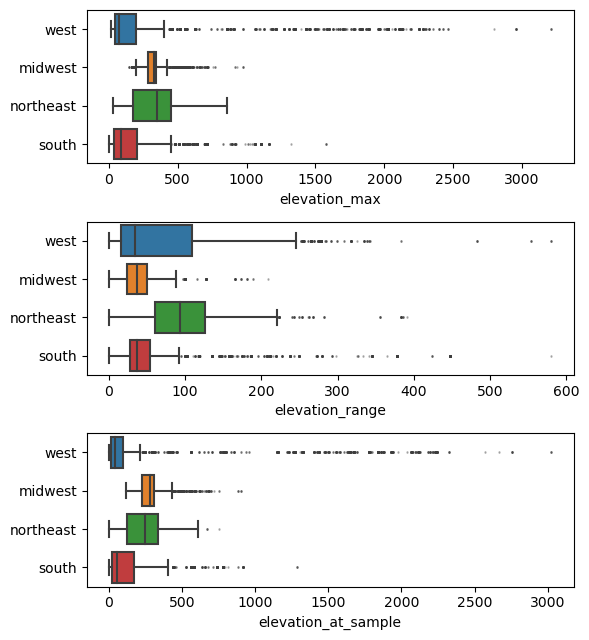

In [44]:
fig, axes = plt.subplots(len(elev_columns), 1, sharey=True, figsize=(6,6.5))

for col, ax in zip(elev_columns, axes):
    sns.boxplot(data=test_features, y='region', x=col, 
                flierprops={'markersize':1, 'alpha':0.3},
                ax=ax)
    ax.set_ylabel('')

plt.tight_layout()

### How does density differ with elevation?

Is there a significant correlation beyond region?

In [91]:
# combine elevation features and actual density
elev_density = test_features[
    ['sample_id', 'elevation_max', 'elevation_range', 'elevation_at_sample']
].drop_duplicates().set_index('sample_id')
assert elev_density.index.is_unique
elev_density['log_density'] = test.loc[elev_density.index].log_density.values
elev_density['region'] = test.loc[elev_density.index].region.values

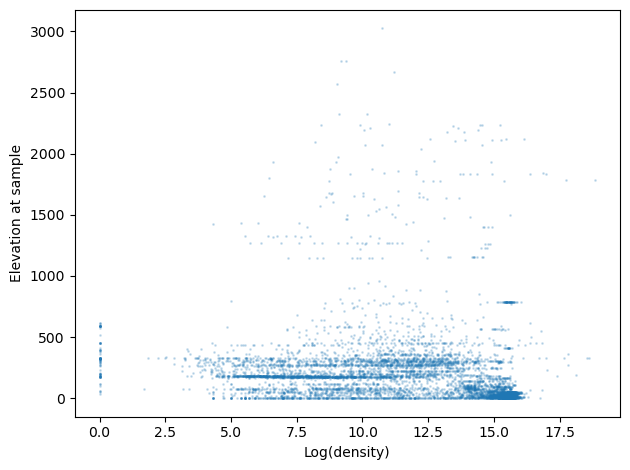

In [79]:
plt.scatter(
    x=elev_density.log_density, y=elev_density.elevation_at_sample,
    s=1,
    alpha=0.2
)
plt.xlabel('Log(density)')
plt.ylabel('Elevation at sample')
plt.tight_layout()

<Axes: xlabel='log_density', ylabel='elevation_at_sample'>

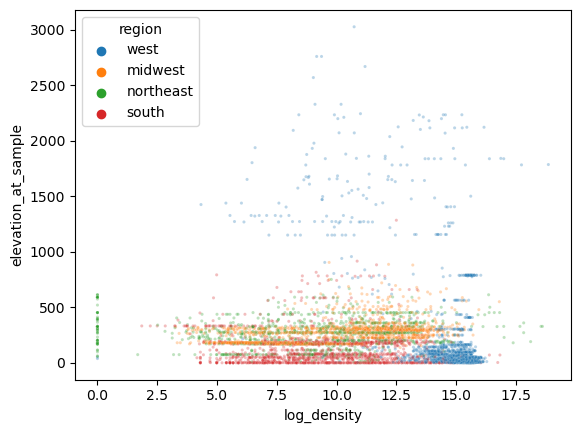

In [89]:
sns.scatterplot(
    data=elev_density,
    x='log_density',
    y='elevation_at_sample',
    hue='region',
    s=5,
    alpha=0.3
)
                

It makes sense that we don't see elevation as significantly helping identify high-severity samples in the west. While lower-elevation samples in the west are very concentrated at high densities, higher-elevation samples in the west have a much broader range of density.

### Which new samples do we get features for?

Are we only covering additional older samples, or does elevation data increase our coverage on newer samples as well?

We get elevation data for 100% of samples.

In [24]:
pd.crosstab(test.date.dt.year, test.has_satellite).sort_index()

has_satellite,False,True
date,,
2013,521,0
2014,602,0
2015,453,74
2016,37,588
2017,68,963
2018,0,777
2019,0,1199
2020,0,546
2021,5,677


There are very few samples post-2017 that we do not get satellite imagery for. It is likely not worth adding elevation data just to help with coverage -- we should only add it if it improves model performance.

### Save out subsets with / without satellite imagery

So that we can instantiate separate `EvaluatePreds` classes, save out two versions of the predictions -- one with only samples that have satellite imagery, one with only samples that *don't* have satellite imagery

In [27]:
tmp_save_dir = AnyPath("tmp_data")
tmp_save_dir.mkdir(exist_ok=True, parents=True)

preds_sat_path = tmp_save_dir / "preds_with_sat.csv"
preds_no_sat_path = tmp_save_dir / "preds_no_sat.csv"

In [28]:
# Save out subset with satellite imagery
preds_sat = preds.loc[test_features[test_features.has_satellite].sample_id.unique()]
print(preds_sat.shape)
preds_sat.to_csv(preds_sat_path, index=True)

(4824, 5)


In [29]:
# Save out subset without satellite imagery
preds_no_sat = preds.loc[test_features[~test_features.has_satellite].sample_id]
print(preds_no_sat.shape)
preds_no_sat.to_csv(preds_no_sat_path, index=True)

(1686, 5)


In [30]:
# Load model
archive = ZipFile(s3_dir / "results/third_sentinel_and_elevation/model.zip", "r")
model = lgb.Booster(model_str=archive.read("lgb_model.txt").decode())
type(model)

lightgbm.basic.Booster

### Instantiate `EvaluatePreds` classes

In [31]:
evals = {}
evals["with_satellite"] = EvaluatePreds(
    true_path, preds_sat_path, "tmp/eval_sat", model
)

2023-08-28 09:47:36.633 | INFO     | cyano.evaluate:__init__:130 - Evaluating on 4,824 samples (of 4,824)


In [32]:
evals["without_satellite"] = EvaluatePreds(
    true_path, preds_no_sat_path, "tmp/eval_sat", model
)

2023-08-28 09:47:40.705 | INFO     | cyano.evaluate:__init__:130 - Evaluating on 1,686 samples (of 1,686)


## Evaluate

#### Severity level

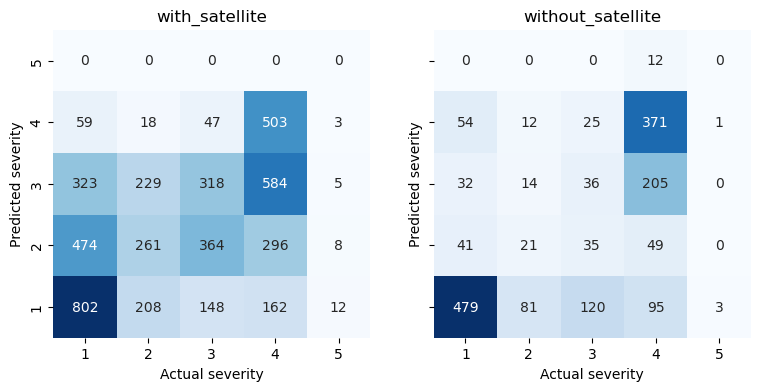

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
for i, key in enumerate(evals.keys()):
    generate_and_plot_crosstab(
        evals[key].y_true_df.severity, evals[key].y_pred_df.severity, ax=axes[i]
    )
    axes[i].set_title(key)

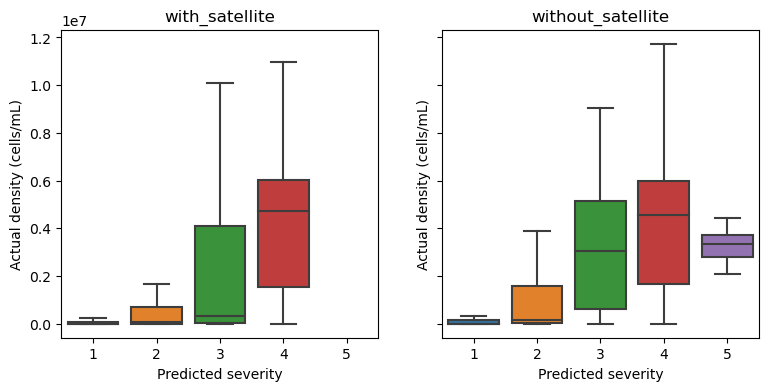

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
for i, key in enumerate(evals.keys()):
    generate_actual_density_boxplot(
        evals[key].y_true_df.density_cells_per_ml,
        evals[key].y_pred_df.severity,
        ax=axes[i],
    )
    axes[i].set_title(key)

In [35]:
# get scores on severity predictions
severity_results = {
    key: evalpreds.calculate_severity_metrics(
        y_true=evalpreds.y_true_df.severity,
        y_pred=evalpreds.y_pred_df.severity,
        region=evalpreds.region,
    )
    for key, evalpreds in evals.items()
}

pd.DataFrame(severity_results).loc[
    [
        "overall_rmse",
        "overall_mae",
        "overall_mape",
        "region_averaged_rmse",
    ]
]

,with_satellite,without_satellite
overall_rmse,1.232001,1.254884
overall_mae,0.875622,0.770463
overall_mape,0.456399,0.343476
region_averaged_rmse,1.19861,1.253071


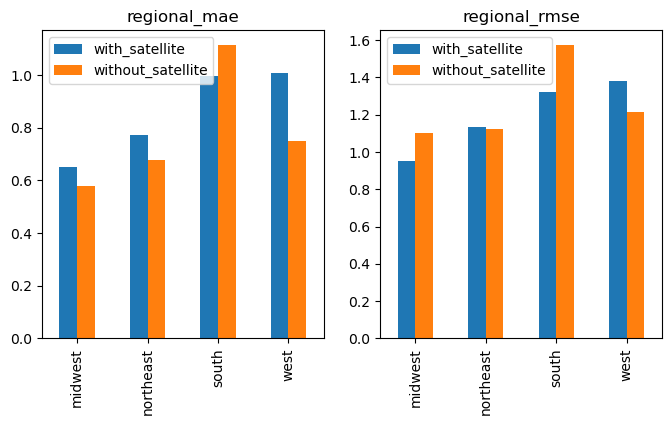

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, metric in enumerate(
    [
        "regional_mae",
        "regional_rmse",
    ]
):
    regional_scores = pd.DataFrame(
        {key: res[metric] for key, res in severity_results.items()}
    )
    regional_scores.plot(kind="bar", ax=axes[i])
    axes[i].set_title(metric)
plt.show()

In [37]:
# See RMSE in detail for regions
regional_scores

,with_satellite,without_satellite
midwest,0.951999,1.102037
northeast,1.135941,1.121635
south,1.324455,1.574600
west,1.382043,1.214011


#### Log(density)

In [38]:
# log density metrics for samples with satellite imagery
evals["with_satellite"].calculate_density_metrics(
    y_true=evals["with_satellite"].y_true_df.log_density,
    y_pred=evals["with_satellite"].y_pred_df.log_density,
    region=evals["with_satellite"].region,
)

{'overall_r_squared': 0.1565541151933354,
 'overall_mape': 768918952080585.5,
 'regional_r_squared': {'midwest': 0.20590177768512885,
  'northeast': -0.17454727160988415,
  'south': -0.7840585035827081,
  'west': -3.1001446926476532}}

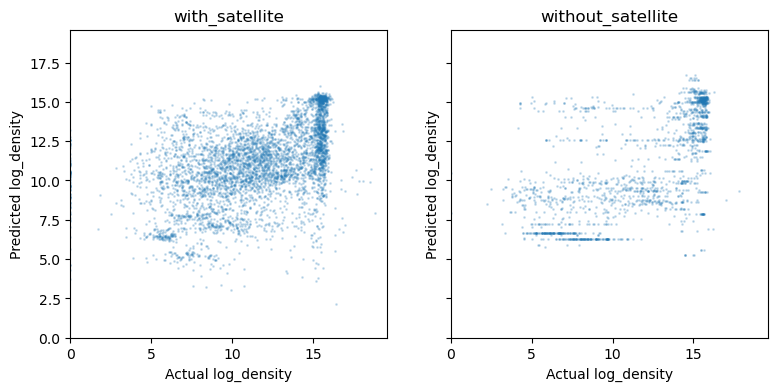

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
for i, key in enumerate(evals.keys()):
    generate_density_scatterplot(
        evals[key].y_true_df.log_density, evals[key].y_pred_df.log_density, ax=axes[i]
    )
    axes[i].set_title(key)

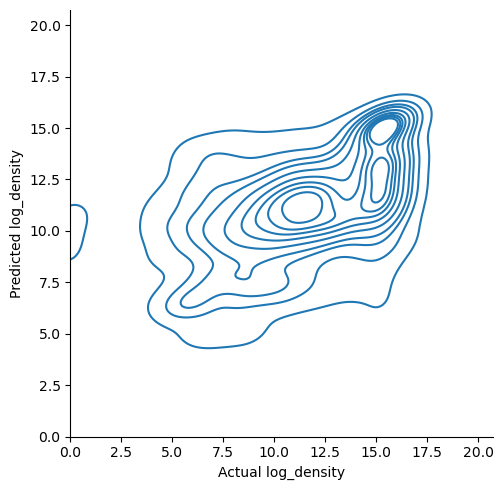

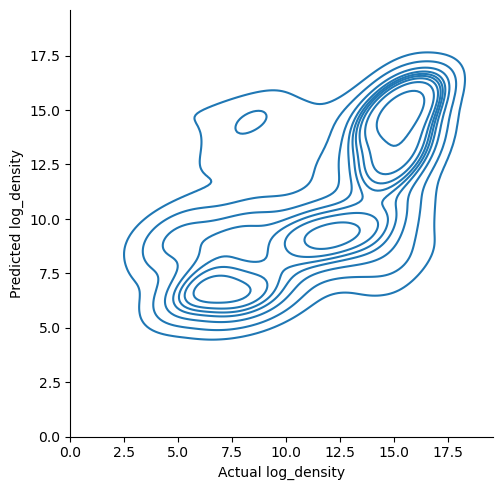

In [42]:
for i, key in enumerate(evals.keys()):
    generate_density_kdeplot(
        evals[key].y_true_df.log_density, evals[key].y_pred_df.log_density
    )

#### Feature importance

In [45]:
feature_importance = pd.read_csv(
    s3_dir / "results/third_sentinel_and_elevation/metrics/feature_importance.csv",
    index_col=0,
)

# what are the top features by importance gain?
feature_importance.sort_values(by="importance_gain", ascending=False).head()

,importance_gain,importance_split
feature,,
elevation_max,1.079148e+06,2201
elevation_range,5.492383e+05,2523
elevation_at_sample,2.444127e+05,2921
month,1.074552e+05,1038
WVP_mean,2.305230e+04,488


In [46]:
# what are the top features by importance split?
feature_importance.sort_values(by="importance_split", ascending=False).head()

,importance_gain,importance_split
feature,,
elevation_at_sample,2.444127e+05,2921
elevation_range,5.492383e+05,2523
elevation_max,1.079148e+06,2201
month,1.074552e+05,1038
NDVI_B07,1.421703e+04,979


**Takeaways**

All of our elevation features are in the top most important features.